In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 


from scipy.stats import skew
from scipy.stats import kurtosistest
import researchpy as rp
import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import kstest


De nuevo, seguiremos trabajando con los datos del alquiler de casas de Madrid. Recordemos que en el primer pair programming eliminamos algunas columnas, por lo que deberemos trabajar con el csv que guardamos en ese ejercicio.
Los objetivos del pair programming de hoy son:
Usaremos el dataset de listings_limpio-2 en el caso que no hayamos llegado a terminar el pair de ayer. Si tenéis el csv de ayer es preferido que uséis ese.
Chequead los outliers y haced la gestión de ellos, como aprendimos en las lecciones de limpieza.
¿Sigue la columma price una distribución nomrmal? Chequeadlo visual y analiticamente.
En caso de que no siga una distribución normal, realizad la transformación necesaria para que se ajuste a una normal.
Chequead la independencia entre las siguientes columnas: neighbourhood_group y room_type
Chequead la heterocedasticidad de la columna room_mtype frente al price

In [17]:
df = pd.read_csv("listings_pair_1.csv", index_col = 0)
df.head(2)

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Chamartín,Private room,59,1,81,0.57,1,149,3
1,Latina,Private room,31,4,33,0.38,2,131,0


Ejercicio 1. Chequead los outliers. Gestiónalos

In [18]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} 

    for col in lista_columnas:
        
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: 
        
            dicc_indices[col] = (list(outliers_data.index))

    return dicc_indices

In [19]:
df_num = df.select_dtypes(exclude = "object")

In [20]:
lista_columnas = list(df_num.columns)
ind = detectar_outliers(lista_columnas, df)

In [21]:
for col in ind:
    s = set()
    s.update(ind[col])

In [22]:
# Índices de las filas que contienen outliers. Recomendación Alejandro/Ana: NO imprimir, es muy largo.
# print(s)

<font color ='skyblue'>Número de registros (filas) que tienen 1 o más outliers

In [23]:
len(s)

2162

In [24]:
df_num.shape

(17606, 7)

<font color = 'skyblue'>Vemos que tenemos 2000 registros que tienen uno o más outliers de 17000, asumimos que es "bastante" por lo que decidimos sustituirlo por la mediana o por la media y no eliminarlos. Vamos a investigar para decidir por cuál de las dos debemos sustituirlos.

In [25]:
df_num.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,17606.000000,17606.000000,17606.000000,17606.000000,17606.000000,17606.000000,17606.000000
mean,106.527150,7.449279,36.328184,1.347131,11.622856,148.076622,6.598035
std,130.223339,36.375985,68.979754,1.383856,27.842846,139.668538,13.367240
min,7.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,40.000000,1.000000,1.000000,0.360000,1.000000,0.000000,0.000000
50%,71.000000,2.000000,7.000000,1.347131,2.000000,104.000000,1.000000
75%,114.000000,3.000000,38.000000,1.510000,7.000000,308.000000,7.000000
max,1000.000000,1125.000000,767.000000,25.000000,199.000000,365.000000,347.000000


<font color='skyblue'> Hemos observado que la media y le mediana son diferentes. Sustituir los registros con outliers por la mediana ya que supone una medida de tendencia central más robusta que la mediana.

In [26]:
for k, v in ind.items():
    median = df[k].median()
    df.loc[v,k] = median
    

In [27]:
df.head(2)

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Chamartín,Private room,59,1,81,0.57,1,149,3
1,Latina,Private room,31,4,33,0.38,2,131,0


In [28]:
df.isna().sum()

neighbourhood_group               0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

Ejercicio 2. Columna Price es normal? Gráfica y analíticamente.

<font color='skyblue'> - Gráficamente:

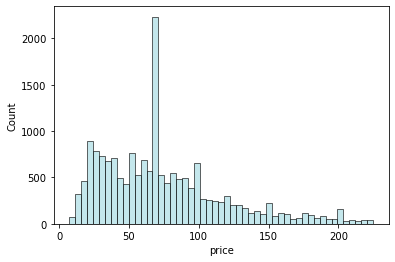

In [29]:
sns.histplot(df["price"], color = 'powderblue');

<font color='skyblue'>Observamos que nuestros datos no siguen una distribución normal. Parece que el reemplazo de nuestros outliers por la mediana ha modificado bastante la distribución .Sin embargo, también hemos observado previamente que nuestros datos no seguían una distribución normal antes del reemplazo. 

 <font color='skyblue'>- Analíticamente:

In [44]:
kstest(df["price"], 'norm')

KstestResult(statistic=0.998366107875447, pvalue=0.0)

<font color='skyblue'> p-valor es menor que 0.05 por lo que nuestros datos no son normales por el método de la curtosis que vimos en el pair anterior.

<font color='skyblue'>Vamos a transformar nuestros datos para que lo sean. Realizamos el test de Shappiro para confirmar si la respuesta es normal. Luego hemos optado por una transformación de `raiz cuadrada`. 

In [45]:
stats.shapiro(df["price"].sample(5000))

ShapiroResult(statistic=0.9819645285606384, pvalue=9.463173446878995e-25)

<font color='skyblue'>Vemos que el p-valor es menor que 0.05 por lo que no podemos decir que la distribución de los datos sea normal. 

<font color='skyblue'> Aquí transformamos por raíz cuadrada

In [46]:
df['price'] = df['price'].apply(lambda x: math.sqrt(x))

In [47]:
kstest(df["price"], 'norm')

KstestResult(statistic=0.9650154421951943, pvalue=0.0)

<font color='skyblue'>Nuestro p-value no se ha modificado tras la transformación.

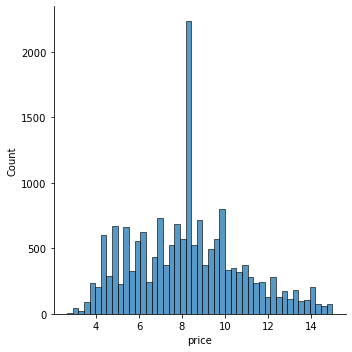

In [34]:
sns.displot(df["price"]);

<font color='skyblue'>Vemos en la gráfica que nuestros datos han cambiado de forma pero no llegan a tomar forma de campana de Gauss. No son normales tras la transformación.

#### 3. Chequead la independencia entre las siguientes columnas: neighbourhood_group y room_type

In [48]:
crosstab, test_results, expected = rp.crosstab(df["neighbourhood_group"], df["room_type"], test= "chi-square", expected_freqs= True,
                                               prop= "cell")

In [49]:
crosstab.head()

room_type                                           
room_type           Entire home/apt Hotel room Private room Shared room    All
neighbourhood_group                                                           
Arganzuela                     3.21       0.01         2.28        0.02   5.52
Barajas                        0.24       0.00         0.52        0.01   0.78
Carabanchel                    1.39       0.01         2.04        0.02   3.46
Centro                        32.93       0.65        11.48        0.65  45.71
Chamartín                      1.76       0.02         1.06        0.03   2.87

In [50]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 60.0) =,1813.8396
1,p-value =,0.0000
2,Cramer's V =,0.1853


<font color='skyblue'>El p-value es 0.00 por lo que afirmamos que no hay independencia entre las variables.

#### 4. Chequead la heterocedasticidad de la columna room_type frente al price

<font color='sky blue'> - Gráficamente:

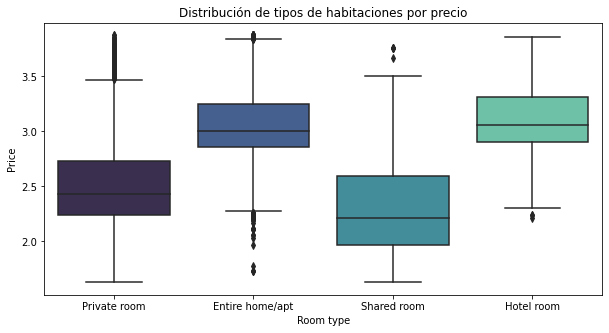

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(x = 'room_type', y = 'price', data = df, palette = 'mako', ax = ax)
ax.set_title('Distribución de tipos de habitaciones por precio')
ax.set_xlabel('Room type')
ax.set_ylabel('Price');

<font color = 'skyblue'> En este boxplot pordemos ver cómo se distribuyen los precios en función del tipo de habitación, teniendo los precios más caros has habitaciones de hotel y los apartamentos que se ofrecen enteros. Como no se distribuyen homogéneamente en todos los tipos de habitacion, podemos afirmar que nuestros datos son heterocedásticos.

<font color = 'sky blue'> - Analíticamente:

In [55]:
df["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

<font color = 'skyblue'> Realizamos los test de Levene, Bartlett y Fligner-Killeen. 

In [56]:
private = df[df["room_type"] == 'Private room']["price"]
entire = df[df["room_type"] == 'Entire home/apt']["price"]
shared = df[df["room_type"] == 'Shared room']["price"]
hotel = df[df["room_type"] == 'Hotel room']["price"]

In [54]:
levene_test = stats.levene(private, entire, shared, hotel, center='median')
levene_test

LeveneResult(statistic=59.93888920411983, pvalue=1.5169278057912727e-38)

In [42]:
bartlett_test = stats.bartlett(private, entire, shared, hotel)
bartlett_test

BartlettResult(statistic=12.199490938962741, pvalue=0.006730114091883674)

In [43]:
fligner_test = stats.fligner(private, entire, shared, hotel, center='median')
fligner_test

FlignerResult(statistic=7.418299962803413, pvalue=0.05969525607390809)

<font color = 'skyblue'> Los resultados obtenidos son todos inferiores a 0.05, lo que indica que nuestros datos no cumplen con la asunción de homocedasticidad y que SI son significativos y podemos rechazar la H0. Son heterecedásticos.